<a href="https://colab.research.google.com/github/guydav/deep-learning-projects/blob/master/notebooks/VAE_ABC_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!kill -9 -1

# VAEs as ABC Summary Functions

Guy Davidson | IL181.014 | Professor Carl Scheffler | 2018-12-01

The project is available here: https://colab.research.google.com/drive/1eNr-k-GIS7ZDTaBYz2DQRGUlIZL9uruu

Note: I moved most of the implementation code to a series of cells fairly in the beginning, after the initial Colab notebook setup, which both makes it easier to resume running if I get allocated into a new machine, and should make it easier for you to reason over the code (and grade it).

## Premise
Likelihood-free methods such as ABC require a distance metric in order to evaluate proposed parameters. With high dimensional data, computing a distanc metric over an entire dataset can become computationally prohibitive. To combat this, a disance measure is computed over a summary function of the data, rather than over the entire data itself. Choosing such a summary function is often difficult. This work explores using the encoder half of a variational autoencoder (VAE) as the summary function in ABC methods.

## Summary of Work and Results
* Implemented a data generating process to arbitrarily mix MNIST digits, navigating some trickery between how PyTorch expects to use the data (floats in the [0, 1] range) and Sklean (bytes, so [0, 255]).
* Improved upon PyTorch's basic variational autoencoder implementation to make extending it, saving models and loading them, and testing them easier.
* Evaluated the VAE-ABC method on a variety of settings, including random testing over which digits comprise the mixtures and which digits are also offered to the model as a distraction, remaining within the realm of toy problems with 2 mixed digits and up to 2 additional digits offered to the models.
    * Note: I'm aware that VAE usually accepts if the distance is smaller than some measure. To make reporting results easier, I simply considered the best result (by score) from each ABC execution as the best proposal. 
* Compared performance to a regular ABC implementation without the VAE - approximately the same speed with slightly better results from the VAE-using variant. 
* Examined a few potential improvements to the basic VAE model, which was only trained on raw (unmixed) MNIST digits:
    * Experimented with biased samplers and distance metric penalties to improve ABC sampler performance.
    * Training on MNIST and subsequently fine-tuning the autoencoder on reconstructing on mixed digits improved the result.
    * Training the autoencoder solely on mixed digits improved the results further.
    * Training a larger VAE (additional layer, units per layer, and latent dimensionality) improved marginally further.
* Implemented a convolutional VAE using convolution operations as the encoder and deconvolution operations as the decoder.
    * With substantially fewer parameters in the model, and the same latent dimensionality as the original VAE, this model outperformed all other models. 
    * Interestingly, training a larger convolutional model (both in number of filters and latent dimensionality) failed to improve upon the smaller convolutional result.
* Implemented ABC-MCMC using a Metropolois-Hastings approach to hopefully explore the latent space better.
    * This required implementing an appropriate proposal sampler over the simplex. After searching around, I implemented Director et al.'s (2017) [SALT, self-adjusting logit-transform proposal](https://www-tandfonline-com.ccl.idm.oclc.org/doi/abs/10.1080/00949655.2017.1376063?src=recsys&journalCode=gscs20), porting over their [R implementation](https://rdrr.io/cran/SALTSampler/f/) to Python.
    * Preliminary results show it is actually not substantially better at exploring the space than the regular ABC. The distribution of results is less skewed, in the sense that the worst results tend to be better than the worst results of regular ABC, but the exploration (even in 4-D space) is slow, such that it needs more iterations to arrive on better solutions.
    * Giving it additional iterations help, but it still needs substantially more in order to compete with standard ABC. I imagine it might fair relatively better in higher dimensions, but I'd need to run that test to be sure.

## Potential Extensions / Next Steps
* Continue iteratively improving the models, potentially exploring more advanced ABC methods such as ABC-SMC and ABC-HMC.
* Test some of these models on the full complexity of the problem - recovering the correct combination with all ten digits. This will require running these tests for substantially longer.
* Perform ablation studies to attempt to isolate which components actually drive the improvement in performance:
    * Biasing the sampler?
    * Increasing the size of the VAE, keeping latent representation dimension equal.
    * Inrcrasing the size of the latent representation, otherwise keeping VAE layer sizes constant.
    * The amount of iterations allowed to sample.
    * The amount of training the VAE receives.
    * Whether or not the VAE is also trained or solely trained on the mixture digits, rather than on MNIST alone.
    * The effect of different choices in the convolutional architecture:
        * Number of layers
        * Number of filters per layer
        * Choice of non-linearity
        * Latent representation dimensionality
* Explore that it might take to get ABC-MCMC better - at what number of iterations does it begin to substantially outperform regular ABC.  

## Set up PyTorch

In [1]:
import sys

!git clone https://github.com/guydav/deep-learning-projects.git
!pip install -q -r deep-learning-projects/requirements.txt
!wandb login 9676e3cc95066e4865586082971f2653245f09b4
sys.path.extend(('./deep-learning-projects', './src/tqdm'))

Cloning into 'deep-learning-projects'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 83 (delta 36), reused 60 (delta 19), pack-reused 0
Unpacking objects: 100% (83/83), done.
tcmalloc: large alloc 1073750016 bytes == 0x619ea000 @  0x7fed7229c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Branch 'colab' set up to track remote branch 'colab' from 'origin'.
Switched to a new branch 'colab'
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
wandb 0.6.32 has requirement python-dateutil>=2.6.1, but you'll have python-dat

## Set up Google Drive access to save/load files

Install packages and authorize, set up directory, mount, ...

In [2]:
!add-apt-repository -y ppa:alessandro-strada/google-drive-ocamlfuse-beta
!apt-get update
!apt-get install google-drive-ocamlfuse
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!google-drive-ocamlfuse -cc

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/alessandro-strada/google-drive-ocamlfuse-beta/ubuntu bionic InRelease [15.4 kB]
Get:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Get:11 http://ppa.launchpad.net/alessandro-strada/google-drive-ocamlfuse-beta/ubuntu bionic/main amd64 Packages [2,017 B]
Get:12 htt

In [5]:
!ls -la "drive/Colab/VAE_ABC"

total 36
drwxr-xr-x 2 root root 4096 Nov 29 14:39 .
drwxr-xr-x 2 root root 4096 Nov 29 14:39 ..
drwxr-xr-x 2 root root 4096 Nov 29 14:57 base_vae
drwxr-xr-x 2 root root 4096 Nov 29 22:52 base_vae_mixed_tuning
drwxr-xr-x 2 root root 4096 Nov 30 16:21 conv_vae
drwxr-xr-x 2 root root 4096 Nov 30 16:51 large_conv_vae
drwxr-xr-x 2 root root 4096 Nov 30 13:29 larger_vae
drwxr-xr-x 2 root root 4096 Nov 29 23:11 test_vae
drwxr-xr-x 2 root root 4096 Nov 30 10:06 vae_mixed_training_only


In [0]:
from projects.vae_abc import *

## Set up dataset and digit mixer

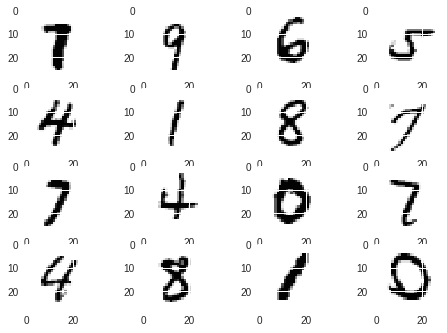

In [7]:
mnist = datasets.MNIST('../data', train=True, download=True)

plt.plot(figsize=(16, 16))

NROWS = 4
NCOLS = 4

for i in range(NROWS * NCOLS):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(mnist.train_data[np.random.randint(mnist.train_data.shape[0])].reshape(28, 28))

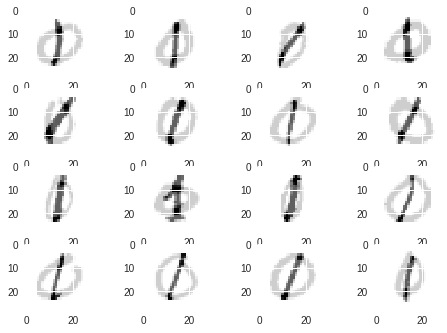

In [8]:
dm = SklearnDigitMixer((0, 1), (0.3, 0.7))
im = dm(16)
im.shape, im[0].shape

plt.plot(figsize=(16, 16))

NROWS = 4
NCOLS = 4

for i in range(NROWS * NCOLS):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(im[i].reshape(28, 28))

## Train a VAE on regular MNIST (all ten digits)

Using PyTorch's reference code as a guide:

https://github.com/pytorch/examples/tree/master/vae

In [9]:
vae = VAE('base_vae').to(device)
vae.load_model(20)
# vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# train_and_test(vae, vae_optimizer, 20, train_loader, test_loader)

0


## Can the VAE reconstruct our generated examples?

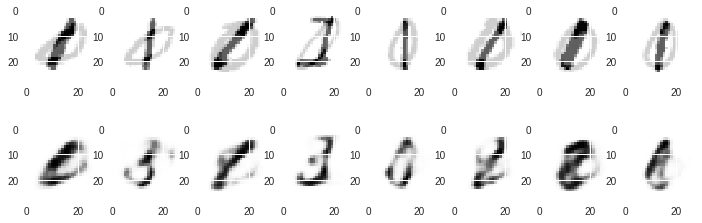

In [10]:
dm = SklearnDigitMixer((0, 1), (0.3, 0.7))
im = dm(8)
plot_reconstruction(vae, im)

## Use the autoencoder as a summary function in ABC

Let's write out the algorithm more clearly:
* Given some pre-generated data from a distribution we don't know
* Sample mixture weights from our prior (uniform over the simplex)
* Generate data according to the generative process with our sampled parameter
* Summarize the data using the VAE's encoder
* Compute mean squared error between the sampled data and 'real' data
    * Pairwise distance between every pair of points, such that order doesn't matter?
    * Substantially more computationally expensive, though...
* Retain the small # of samples with the lowest distances

### Next steps:
* Try harder variants of this problem:
    * Performing inference over more digits (give the model an option to try digits that didn't contribute)
        * Above but with an L1 sparsity penalty to encourage only using a few digits?
    * Generating a mixture of more digits
    * Try this over different generting digits to see the sensitivity to which specific problem? Or which additional digits are in the pool?
    * Try adding additional noise and seeing how well the model handles that?
* Try training the autoencoder on digit mixtures as well, and see if that improves performance?
* Compare to not using the encoder (both in results and in time taken)

### Potential extensions:
* Try ABC-MCMC and compare to results with standard ABC
* Try a Bayesian optimization sort of treatment?
* Try a VAE augmented with the class probabilities, or a convolutional VAE for additional expressivity?


In [11]:
results = abc(default_digits, train_images, uniform_two_param_sampler, 
              vae, metric)
print()
print(results[:5])

./src/tqdm/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)




[(2.8496630260623266, array([0.29681426, 0.70318574])), (2.865546483063281, array([0.25891305, 0.74108695])), (2.922899100052035, array([0.23188522, 0.76811478])), (2.9231292340674035, array([0.36259841, 0.63740159])), (2.9316359096936235, array([0.35642608, 0.64357392]))]


What if we add more iterations? Do we get even closer?

In [12]:
results_1000_iter = abc(default_digits, train_images, uniform_two_param_sampler, 
                        vae, metric, n_iter=1000)
print()
print(results_1000_iter[:5])



[(2.841840643811453, array([0.26376616, 0.73623384])), (2.858207244942117, array([0.26105984, 0.73894016])), (2.8679555660583627, array([0.27016085, 0.72983915])), (2.8684962398227434, array([0.22975278, 0.77024722])), (2.869416308019461, array([0.35593575, 0.64406425]))]


Ever so slightly,  but that's random search for you.

### First harder version: additional classes

What if we allow the model to sample from 0/1/2/3, instead of just 0 and 1, will it recover something similar?

In [14]:
def uniform_four_param_sampler(seed):
    return np.random.dirichlet((1, 1, 1, 1))

def four_digit_mixer_generator(valid_digits, params):
    return SklearnDigitMixer(valid_digits, params)

default_four_digits = (0, 1, 2, 3)

four_digit_results = abc(default_four_digits, train_images, uniform_four_param_sampler, 
                         vae, metric, n_iter=1000)

print(four_digit_results[:5])


[(2.601285921318822, array([0.21623715, 0.5460499 , 0.10796997, 0.12974298])), (2.6113912869015286, array([0.22079943, 0.52876315, 0.10762998, 0.14280744])), (2.6309425816861327, array([0.21354878, 0.61640413, 0.05637526, 0.11367183])), (2.64263205882305, array([0.20958845, 0.52412421, 0.18610245, 0.08018489])), (2.6447250358068817, array([0.18673803, 0.52373594, 0.13939144, 0.1501346 ]))]


Not as cleanly. What if I either change the prior, or add a scoring penalty to encourage sparsity?

In [15]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 2, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)

biased_four_digit_results = abc(default_four_digits, train_images, biaesd_four_param_sampler, 
                                vae, metric, n_iter=1000)

print(biased_four_digit_results[:5])


[(2.630457911916551, array([0.21398098, 0.60660219, 0.14749391, 0.03192292])), (2.639584465371348, array([0.22700575, 0.54679332, 0.08718171, 0.13901922])), (2.6541286477400967, array([0.26133475, 0.57516424, 0.06666851, 0.0968325 ])), (2.65846245739949, array([0.30877815, 0.53823207, 0.01942205, 0.13356772])), (2.6645541019707073, array([0.32931554, 0.50874554, 0.03701146, 0.12492745]))]


In [17]:
penalty_weight = 0.5

def metric_with_penalty(params, generated, train):
    return np.mean(cdist(generated, train)) - penalty_weight * np.sum(params ** 2)

penalized_four_digit_results = abc(default_four_digits, train_images, uniform_four_param_sampler, 
                         vae, metric_with_penalty, n_iter=1000)

print(penalized_four_digit_results[:5])



[(2.417204943075559, array([0.19757317, 0.63840166, 0.1010087 , 0.06301647])), (2.4258756487773114, array([0.25324327, 0.60004955, 0.03262561, 0.11408157])), (2.4262094446037703, array([0.24290177, 0.57117914, 0.02887644, 0.15704265])), (2.4266246634015527, array([0.17248455, 0.59236074, 0.08774782, 0.14740689])), (2.4354458206322356, array([0.2366517 , 0.53318264, 0.14688184, 0.08328382]))]


Interestingly, adding a penalty provides a stronger solution than changing the prior. Let's try stronger versions of both the prior and penalty:

In [18]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((50, 25, 5, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)

biased_four_digit_results = abc(default_four_digits, train_images, biaesd_four_param_sampler, 
                                vae, metric, n_iter=1000)

print(biased_four_digit_results[:5])


[(2.6872513886916196, array([0.24319714, 0.59671979, 0.02372619, 0.13635688])), (2.693516332243356, array([0.31906358, 0.58653881, 0.02831543, 0.06608218])), (2.7100510703744685, array([0.25245893, 0.62333364, 0.1035062 , 0.02070123])), (2.7115960977812508, array([0.27173724, 0.6335214 , 0.08577052, 0.00897084])), (2.7130311481362375, array([0.29512511, 0.61779734, 0.05414381, 0.03293373]))]


In [19]:
penalty_weight = 1.0

def metric_with_penalty(params, generated, train):
    return np.mean(cdist(generated, train)) - penalty_weight * np.sum(params ** 2)

penalized_four_digit_results = abc(default_four_digits, train_images, uniform_four_param_sampler, 
                         vae, metric_with_penalty, n_iter=1000)

print(penalized_four_digit_results[:5])



[(2.175939193027247, array([0.16852352, 0.71749943, 0.02676165, 0.08721541])), (2.2113656079276636, array([0.19772225, 0.63100452, 0.1499033 , 0.02136992])), (2.211432293459445, array([0.1033128 , 0.74834087, 0.05498865, 0.09335768])), (2.215825332782198, array([0.20224454, 0.69692225, 0.04817467, 0.05265853])), (2.2195279793396656, array([0.19632185, 0.57632221, 0.07527676, 0.15207919]))]


With a stronger prior, the model actually behaves better than with a stronger penalty. A mixture of both might prove even better? 

In [20]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((50, 25, 5, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)

penalty_weight = 0.5

def metric_with_penalty(params, generated, train):
    return np.mean(cdist(generated, train)) - penalty_weight * np.sum(params ** 2)

penalized_biased_four_digit_results = abc(default_four_digits, train_images, biaesd_four_param_sampler, 
                                          vae, metric_with_penalty, n_iter=1000)

print(penalized_biased_four_digit_results[:5])


[(2.4298098938679904, array([0.23183842, 0.63742707, 0.0651615 , 0.06557301])), (2.4374208895357348, array([0.30371007, 0.57581608, 0.09793041, 0.02254343])), (2.4430617393380647, array([0.24698714, 0.67009019, 0.06839684, 0.01452582])), (2.448540629596751, array([0.24687058, 0.61600443, 0.02507816, 0.11204683])), (2.4563586211969084, array([0.29244461, 0.64196817, 0.0018987 , 0.06368852]))]


## We solved one problem. How do we fare in general?

To check this, we'll randomize a pair of digits and mixture probabilities, and see how well this method works for a variety of different settings. I'll start with mixtures of two digits, with no extra digits available to the model, and no noise. I'll then progress to more complicated settings

In [21]:
def simple_two_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p)


abc_params = dict(prior_sampler=uniform_two_param_sampler,
                  model=vae, metric=metric)

test_results = randomized_test(simple_two_prob_generator, abc, abc_params)

0.15352408714314822


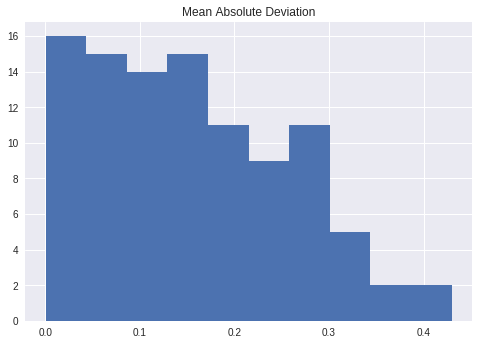

Best:
(array([6, 8]), (0.4190921594680178, 0.5809078405319822), (3.4790690013871193, array([0.43256001, 0.56743999])))
(array([5, 0]), (0.4962842679807945, 0.5037157320192055), (3.4961777654793695, array([0.50436436, 0.49563564])))
(array([5, 2]), (0.4812157216635339, 0.5187842783364661), (3.713314118783379, array([0.49472134, 0.50527866])))
(array([6, 3]), (0.46363792295541584, 0.5363620770445842), (3.571996742177486, array([0.46309475, 0.53690525])))
(array([5, 3]), (0.5640812022829059, 0.4359187977170941), (3.710778278888561, array([0.56502105, 0.43497895])))
Worst:
(array([5, 3]), (0.8894655953851329, 0.11053440461486708), (4.464965085858293, array([0.54798451, 0.45201549])))
(array([2, 6]), (0.8514820720965613, 0.14851792790343865), (4.332455967972572, array([0.50098164, 0.49901836])))
(array([5, 2]), (0.8790703044404985, 0.1209296955595015), (4.419267399291532, array([0.52574019, 0.47425981])))
(array([8, 7]), (0.8507234816339214, 0.14927651836607858), (4.169349361885741, array([

In [22]:
analyze_results(test_results)

That's a mean absolute deviation of about 0.15 in mixure weights. Really not very impressive, albeit with a fairly small number of samples and iterations. But also nothing awful. 

These results are not very surprising. I'm not sure any of these would be statistically significant, but it looks like 0, 1, and 5 tend to be more perceptually unique, whereas 7, 8, and 9 substantially less so.



## Timing and results comparison

With and without the encoder

In [0]:
def abc_no_encoder(valid_digits, train, prior_sampler, metric, 
                   generator=SklearnDigitMixer,
                   n_iter=100, use_tqdm=True):
    results = []
    
    if use_tqdm:
        iterator = tqdm.tnrange(n_iter)
    else:
        iterator = range(n_iter)
    
    for i in iterator:
        params = prior_sampler(i)
        generated_data = generator(valid_digits, params)(train.shape[0])
        distance = metric(params, generated_data, train)
        results.append((distance, params))
        
    results.sort()
    return results

In [24]:
def time_with_encoder(): 
        return abc(default_digits, train_images, uniform_two_param_sampler,
                   vae, metric, n_iter=1000)

encoder_time, encoder_results = timeit.timeit('time_with_encoder()', number=1, globals=globals())

def time_without_encoder(): 
    return abc_no_encoder(default_digits, train_images, uniform_two_param_sampler, 
                          metric, n_iter=1000)

no_encoder_time, no_encoder_results = timeit.timeit('time_without_encoder()', number=1, globals=globals())

print(f'With encoder: {encoder_time:.2f}s, {encoder_results[0]}')
print(f'Without encoder: {no_encoder_time:.2f}s, {no_encoder_results[0]}')


NameError: ignored

Doesn't look much better, but might scale better, both in accuracy and in runtime, to substantially larger examples than 28 x 28.

Let's examine how the non-encoded version fares on average over more examples:

In [25]:
no_encoder_abc_params = dict(prior_sampler=uniform_two_param_sampler, 
                             metric=metric)

no_encoder_test_results = randomized_test(simple_two_prob_generator, 
                                          abc_no_encoder, no_encoder_abc_params)

0.1645385750885636


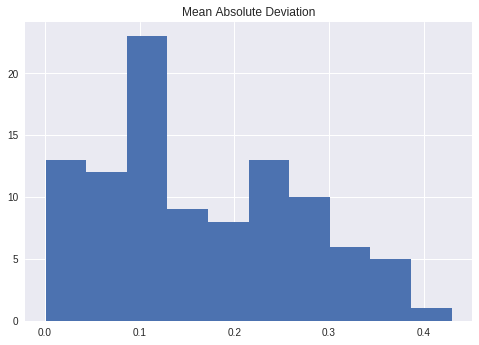

Best:
(array([5, 3]), (0.5640812022829059, 0.4359187977170941), (6.757182089048102, array([0.56502105, 0.43497895])))
(array([2, 7]), (0.4206265914851953, 0.5793734085148047), (6.438418546853698, array([0.43015868, 0.56984132])))
(array([4, 6]), (0.5929716643034274, 0.4070283356965726), (6.3732054471696165, array([0.58735621, 0.41264379])))
(array([7, 1]), (0.3806168783097418, 0.6193831216902582), (5.155795309792685, array([0.36982962, 0.63017038])))
(array([6, 0]), (0.6260729683081296, 0.37392703169187036), (6.733270554085709, array([0.61183385, 0.38816615])))
Worst:
(array([5, 2]), (0.8790703044404985, 0.1209296955595015), (7.8393830387978785, array([0.52574019, 0.47425981])))
(array([5, 4]), (0.8539823730967038, 0.14601762690329623), (7.648358701734984, array([0.48702758, 0.51297242])))
(array([5, 3]), (0.8894655953851329, 0.11053440461486708), (7.736781029125658, array([0.51970099, 0.48029901])))
(array([1, 8]), (0.12766531938289927, 0.8723346806171007), (7.119946947434625, array([

In [26]:
analyze_results(no_encoder_test_results)

On the balance, it looks like the VAE-based method is a little bit more accurate on average, and the two broadly seem to struggle with the same digits. 

## Let's get a sense for how much harder the problem is with a third possible digit

Let's assume the prior is somewhat biased, but avoid the penalty as used before

In [27]:
def biased_three_param_sampler(seed):
    prior_counts = np.array((20, 10, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_three_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0)


third_digit_abc_params = dict(prior_sampler=biased_three_param_sampler,
                  model=vae, metric=metric)

third_digit_test_results = randomized_test(simple_three_prob_generator, abc, 
                                           third_digit_abc_params)

0.1544493926700366


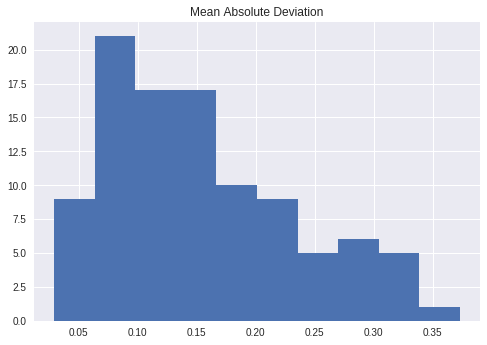

Best:
(array([4, 3, 7]), (0.5026423846390212, 0.4973576153609788, 0), (3.3072836068814113, array([0.48548157, 0.47088895, 0.04362949])))
(array([1, 5, 2]), (0.8641032677244527, 0.13589673227554733, 0), (3.6415578757887923, array([0.80947741, 0.15857911, 0.03194348])))
(array([1, 0, 6]), (0.6145525173459635, 0.3854474826540365, 0), (2.8912714157127994, array([0.63138861, 0.3402119 , 0.02839949])))
(array([1, 9, 4]), (0.6381276338710106, 0.36187236612898943, 0), (3.2700091834100387, array([0.63730296, 0.31328419, 0.04941285])))
(array([0, 2, 1]), (0.580969718172801, 0.41903028182719904, 0), (3.366944596249763, array([0.50506015, 0.4632941 , 0.03164574])))
Worst:
(array([5, 1, 3]), (0.5940967251723838, 0.40590327482761623, 0), (3.6348278122299087, array([0.11053057, 0.59810951, 0.29135992])))
(array([8, 7, 9]), (0.5377336156844794, 0.4622663843155206, 0), (3.409792830332682, array([0.39317947, 0.11368195, 0.49313858])))
(array([0, 5, 9]), (0.3675926547851668, 0.6324073452148332, 0), (3.45

In [28]:
analyze_results(third_digit_test_results)

## interestingly, not much worse. And four digits?

In [29]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                  model=vae, metric=metric)

four_digit_test_results = randomized_test(simple_four_prob_generator, abc, 
                                           four_digit_abc_params)

0.14719889477886297


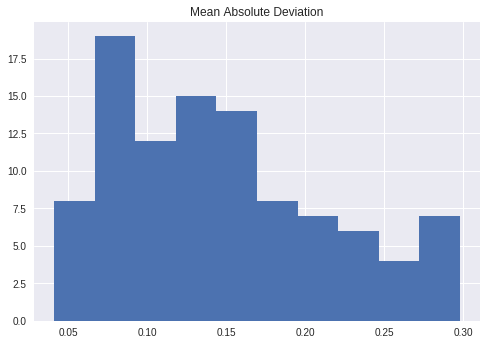

Best:
(array([8, 6, 4, 2]), (0.6177504913956718, 0.38224950860432816, 0, 0), (3.409944550190545, array([0.52561964, 0.43225052, 0.01678426, 0.02534558])))
(array([7, 0, 1, 3]), (0.5826675935593907, 0.4173324064406093, 0, 0), (3.16279453910178, array([0.50067441, 0.42789434, 0.04315623, 0.02827502])))
(array([6, 4, 7, 9]), (0.4890119855741374, 0.5109880144258626, 0, 0), (3.493709234837396, array([0.3715002 , 0.54715466, 0.07233543, 0.00900972])))
(array([7, 0, 4, 1]), (0.5284439270935982, 0.4715560729064018, 0, 0), (3.058529920056446, array([0.50948932, 0.37296975, 0.0552565 , 0.06228443])))
(array([8, 0, 7, 6]), (0.6565916241096186, 0.3434083758903814, 0, 0), (3.0884558109623144, array([0.57127219, 0.30130603, 0.00162843, 0.12579335])))
Worst:
(array([2, 4, 6, 7]), (0.6273662386149391, 0.3726337613850609, 0, 0), (3.59142956266957, array([0.28502441, 0.15326844, 0.02395065, 0.5377565 ])))
(array([7, 8, 0, 9]), (0.546030189428647, 0.453969810571353, 0, 0), (3.3141653744901225, array([0.3

In [30]:
analyze_results(four_digit_test_results)

## Let's try tuning the autoencoder on mixtures of digits, rather than just singles

Starting with only mixtures of two digits, although nothing in principle stops from going further.

Given the 60,000 training images in MNIST (10 digits x 6000 images each), we ostensibly have as many as $60000 \times 54000 = 3. 24 \times 10^9$ potential two-digit mixtures, and that's without even considering the weighting scheme... to keep the epochs comparable to the regular MNIST, I will treat each 60,000 as an epoch, without going to great lengths to guarantee that digits are sampled equally, and assuming the law of large numbers will do its thing. 

(Note: moved the code generating the mixture dataset up as well)

Sample a few images from this generator, to make sure it works as we expect



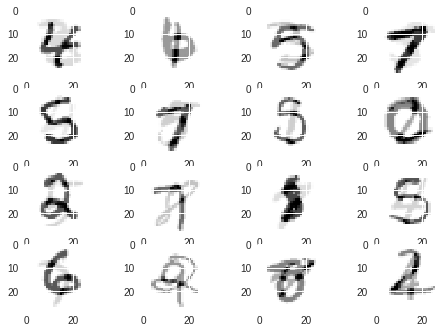

In [31]:
plt.plot(figsize=(16, 16))

NROWS = 4
NCOLS = 4

for ax_index, image_index in enumerate(np.random.randint(0, MNIST_TRAIN_END, NROWS * NCOLS)):
    ax = plt.subplot(4, 4, ax_index + 1)
    ax.imshow(mixed_digit_train_dataset[image_index][0].cpu().numpy().reshape(28, 28))

Looks good to me. Let's create a new model, train 20 epochs with regular MNIST, and tune for another 20 epochs with the mixtures

(I could have, of course, loaded the weights from the previous VAE - but with a GPU the training only takes a few minutes, and then this script is runnable as-is, without copying weights externally or modifying the VAE model class to load weights from another model. All doable things, but...)

In [33]:
import torch.optim as optim

mixed_tuning_vae = VAE('base_vae_mixed_tuning').to(device)
mixed_tuning_vae_optimizer = optim.Adam(mixed_tuning_vae.parameters(), lr=1e-3)
train_and_test(mixed_tuning_vae, mixed_tuning_vae_optimizer, 20,
              train_loader, test_loader)

0
Starting Train Epoch 1




====> Epoch: 1 Average train loss: 158.2176


AttributeError: ignored

Let's plot random digit reconstructions before and after the tuning

Before:

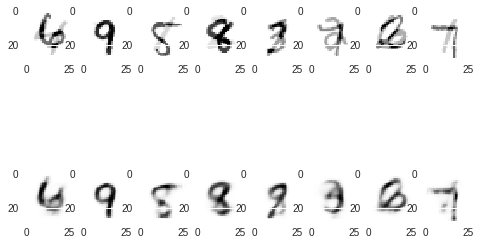

In [0]:
tensor_im = torch.stack([mixed_digit_test_dataset[i][0] for i in range(8)])
plot_reconstruction(mixed_tuning_vae, tensor_im)

In [0]:
def dataset_epoch_callback(epoch):
    mixed_digit_train_dataset.epoch = epoch
    mixed_digit_test_dataset.epoch = epoch
    
    
train_and_test(mixed_tuning_vae, mixed_tuning_vae_optimizer, 20, 
              mixed_digit_train_loader, mixed_digit_test_loader,
              dataset_epoch_callback, 21)

Effectively no progress on the loss (before I accidentally erased the output). Does it get any better at reconstructing?

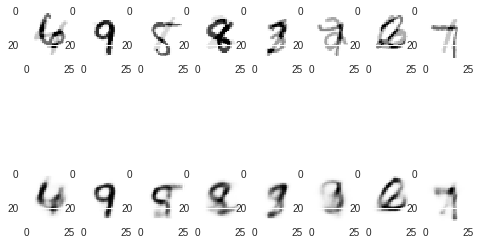

In [0]:
tensor_im = torch.stack([mixed_digit_test_dataset[i][0] for i in range(8)])
plot_reconstruction(mixed_tuning_vae, tensor_im)

By eyeballing alone, who knows, let's see if this will translate to improved inference performance. Let's find out!

In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


mixed_tuning_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=mixed_tuning_vae, metric=metric)

mixed_tuning_four_digit_test_results = randomized_test(
    simple_four_prob_generator, abc, mixed_tuning_four_digit_abc_params)

0.14119901520319303


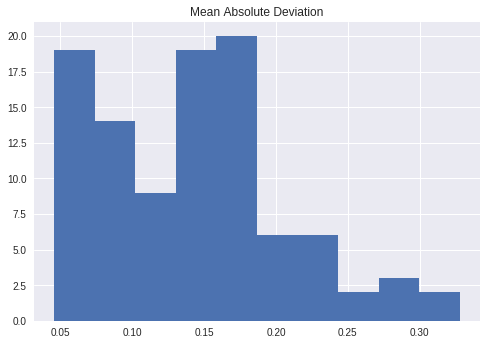

Best:
(array([8, 6, 3, 9]), (0.5745975992025208, 0.42540240079747915, 0, 0), (4.365200566539599, array([0.55250695, 0.34921191, 0.0096887 , 0.08859244])))
(array([8, 2, 6, 7]), (0.38486821491691836, 0.6151317850830816, 0, 0), (4.497627977226161, array([0.38650534, 0.51995344, 0.09159969, 0.00194152])))
(array([4, 1, 6, 3]), (0.24929696656525302, 0.750703033434747, 0, 0), (4.251536218237232, array([0.30418236, 0.65268646, 0.03039974, 0.01273144])))
(array([5, 7, 0, 6]), (0.6275899959661118, 0.37241000403388824, 0, 0), (4.720216207857997, array([0.54212793, 0.36667532, 0.04667037, 0.04452638])))
(array([0, 9, 5, 4]), (0.38045277707524106, 0.619547222924759, 0, 0), (4.311533055034211, array([0.30900805, 0.58356177, 0.08819926, 0.01923093])))
Worst:
(array([5, 0, 6, 7]), (0.8645310079016401, 0.13546899209835994, 0, 0), (5.237670755934638, array([0.3133705 , 0.50324948, 0.09500979, 0.08837023])))
(array([5, 3, 4, 2]), (0.7640972290640157, 0.23590277093598433, 0, 0), (5.014235115679213, arra

In [0]:
analyze_results(mixed_tuning_four_digit_test_results)

## Incrementally better. 

What if, however, we train the VAE from scratch only on the mixed digits - will that improve or detract performance?

In [0]:
def dataset_epoch_callback(epoch):
    mixed_digit_train_dataset.epoch = epoch
    mixed_digit_test_dataset.epoch = epoch

mixed_training_vae = VAE('vae_mixed_training_only').to(device)
mixed_training_vae_optimizer = optim.Adam(mixed_training_vae.parameters(), lr=1e-3)
train_and_test(mixed_training_vae, mixed_training_vae_optimizer, 20,
              mixed_digit_train_loader, mixed_digit_test_loader,
              dataset_epoch_callback)


Starting Train Epoch 1




====> Epoch: 1 Average train loss: 194.0267
====> Test set loss: 174.8526
Starting Train Epoch 2




====> Epoch: 2 Average train loss: 172.1139
====> Test set loss: 169.4225
Starting Train Epoch 3




====> Epoch: 3 Average train loss: 169.0395
====> Test set loss: 167.6304
Starting Train Epoch 4




====> Epoch: 4 Average train loss: 167.8208
====> Test set loss: 166.8135
Starting Train Epoch 5




====> Epoch: 5 Average train loss: 167.1183
====> Test set loss: 166.5151
Starting Train Epoch 6




====> Epoch: 6 Average train loss: 166.6456
====> Test set loss: 165.9331
Starting Train Epoch 7




====> Epoch: 7 Average train loss: 166.2031
====> Test set loss: 165.4502
Starting Train Epoch 8




====> Epoch: 8 Average train loss: 166.0541
====> Test set loss: 165.4527
Starting Train Epoch 9




====> Epoch: 9 Average train loss: 165.8266
====> Test set loss: 165.5470
Starting Train Epoch 10




====> Epoch: 10 Average train loss: 165.6792
====> Test set loss: 165.3033
Starting Train Epoch 11




====> Epoch: 11 Average train loss: 165.6127
====> Test set loss: 165.3512
Starting Train Epoch 12




====> Epoch: 12 Average train loss: 165.4641
====> Test set loss: 165.0635
Starting Train Epoch 13




====> Epoch: 13 Average train loss: 165.4264
====> Test set loss: 164.9280
Starting Train Epoch 14




====> Epoch: 14 Average train loss: 165.0563
====> Test set loss: 164.8415
Starting Train Epoch 15




====> Epoch: 15 Average train loss: 165.2213
====> Test set loss: 164.7846
Starting Train Epoch 16




====> Epoch: 16 Average train loss: 164.8319
====> Test set loss: 164.6406
Starting Train Epoch 17




====> Epoch: 17 Average train loss: 164.7758
====> Test set loss: 164.4929
Starting Train Epoch 18




====> Epoch: 18 Average train loss: 164.7613
====> Test set loss: 164.5497
Starting Train Epoch 19




====> Epoch: 19 Average train loss: 165.0406
====> Test set loss: 164.8238
Starting Train Epoch 20




====> Epoch: 20 Average train loss: 164.9195
====> Test set loss: 164.4911


The loss looks almost identical. Let's see if this model performs any better as an encoder for the mixed digits?

In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


mixed_training_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=mixed_training_vae, metric=metric)

mixed_training_four_digit_test_results = randomized_test(
    simple_four_prob_generator, abc, mixed_training_four_digit_abc_params)

0.13722259016078758


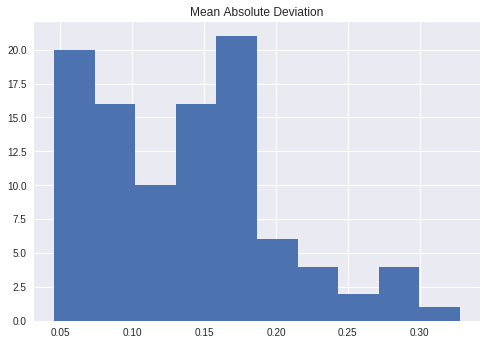

Best:
(array([8, 2, 6, 7]), (0.38486821491691836, 0.6151317850830816, 0, 0), (4.527325126638741, array([0.38650534, 0.51995344, 0.09159969, 0.00194152])))
(array([5, 7, 0, 6]), (0.6275899959661118, 0.37241000403388824, 0, 0), (4.69205191100696, array([0.54212793, 0.36667532, 0.04667037, 0.04452638])))
(array([1, 2, 3, 0]), (0.695898050722928, 0.304101949277072, 0, 0), (4.136979335542623, array([0.59929554, 0.30473075, 0.06817425, 0.02779946])))
(array([4, 1, 6, 3]), (0.24929696656525302, 0.750703033434747, 0, 0), (4.3051469408642875, array([0.30418236, 0.65268646, 0.03039974, 0.01273144])))
(array([8, 6, 3, 9]), (0.5745975992025208, 0.42540240079747915, 0, 0), (4.409414910888547, array([0.55250695, 0.34921191, 0.0096887 , 0.08859244])))
Worst:
(array([8, 7, 6, 1]), (0.7695227379278106, 0.23047726207218944, 0, 0), (4.65295627431174, array([0.23559896, 0.21618463, 0.06053345, 0.48768296])))
(array([5, 0, 6, 7]), (0.8645310079016401, 0.13546899209835994, 0, 0), (5.117975025749233, array([

In [0]:
analyze_results(mixed_training_four_digit_test_results)

Ever so incrementally better. We're inching toward a lower and lower MAD, but I'm curious to see if there's anything I can do to make it substantially better. 

At some point it might be interesting to also play around with a model trying to solve the full problem, that is, over all ten digits, but I'll run that last since a 10 dimensional problem will likely take much longer to sample

## What is the effect of the size of the VAE?

To check that, I implemented the `LargerVAE` model, with an additional layer and a larger latent representation. If I wanted to be more thorough I'd do a full ablation study, adding either the layer or increasing the latent size, and comparing a few different configuration, but for our exploratory purposes doing both simultaneously should be fine.

Let's train one of those on the original problem (reconstructing MNIST), and test it for our encoder purposes, and then tune it with the mixture digits and see if that helps. It might take more than 20 epochs to plateau, since it's a larger model, but we'll see.

In [0]:
larger_vae = LargerVAE('larger_vae').to(device)
larger_vae_optimizer = optim.Adam(larger_vae.parameters(), lr=1e-3)
train_and_test(larger_vae, larger_vae_optimizer, 20,
              train_loader, test_loader, latent_size=30)

0
Starting Train Epoch 1




====> Epoch: 1 Average train loss: 178.7199
====> Test set loss: 143.3360
Starting Train Epoch 2




====> Epoch: 2 Average train loss: 132.2925
====> Test set loss: 123.2307
Starting Train Epoch 3




====> Epoch: 3 Average train loss: 120.0933
====> Test set loss: 115.7937
Starting Train Epoch 4




====> Epoch: 4 Average train loss: 114.5679
====> Test set loss: 111.6577
Starting Train Epoch 5




====> Epoch: 5 Average train loss: 111.1591
====> Test set loss: 109.1860
Starting Train Epoch 6




====> Epoch: 6 Average train loss: 109.0289
====> Test set loss: 107.8616
Starting Train Epoch 7




====> Epoch: 7 Average train loss: 107.6235
====> Test set loss: 106.4419
Starting Train Epoch 8




====> Epoch: 8 Average train loss: 106.4946
====> Test set loss: 105.1889
Starting Train Epoch 9




====> Epoch: 9 Average train loss: 105.5439
====> Test set loss: 104.9600
Starting Train Epoch 10




====> Epoch: 10 Average train loss: 104.8690
====> Test set loss: 104.0079
Starting Train Epoch 11




====> Epoch: 11 Average train loss: 104.2016
====> Test set loss: 103.6724
Starting Train Epoch 12




====> Epoch: 12 Average train loss: 103.8447
====> Test set loss: 103.2618
Starting Train Epoch 13




====> Epoch: 13 Average train loss: 103.3813
====> Test set loss: 102.9172
Starting Train Epoch 14




====> Epoch: 14 Average train loss: 103.0059
====> Test set loss: 102.6541
Starting Train Epoch 15




====> Epoch: 15 Average train loss: 102.6398
====> Test set loss: 102.5969
Starting Train Epoch 16




====> Epoch: 16 Average train loss: 102.4478
====> Test set loss: 102.6894
Starting Train Epoch 17




====> Epoch: 17 Average train loss: 102.1517
====> Test set loss: 101.9287
Starting Train Epoch 18




====> Epoch: 18 Average train loss: 101.9157
====> Test set loss: 102.1309
Starting Train Epoch 19




====> Epoch: 19 Average train loss: 101.6493
====> Test set loss: 101.8360
Starting Train Epoch 20




====> Epoch: 20 Average train loss: 101.4769
====> Test set loss: 101.6872


Reaches just about the same loss. Does it function any better as an encoder?

In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


larger_vae_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=larger_vae, metric=metric)

larger_vae_four_digit_test_results = randomized_test(
    simple_four_prob_generator, abc, larger_vae_four_digit_abc_params)

0.1316063004469626


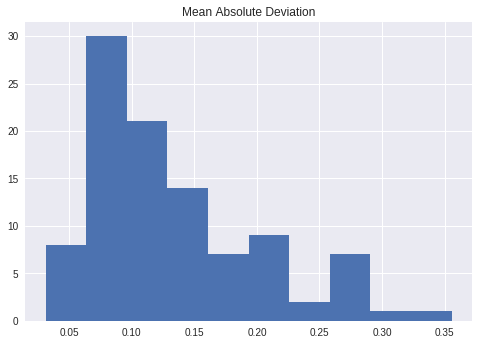

Best:
(array([8, 7, 0, 9]), (0.22500498865678403, 0.774995011343216, 0, 0), (2.667729478555664, array([0.24917887, 0.71285252, 0.02544646, 0.01252215])))
(array([8, 6, 4, 2]), (0.6177504913956718, 0.38224950860432816, 0, 0), (2.5378900075901822, array([0.54199665, 0.4116996 , 0.02442271, 0.02188104])))
(array([4, 6, 5, 9]), (0.6273904021758242, 0.3726095978241758, 0, 0), (2.5887351868680817, array([0.52968275, 0.38216431, 0.03806751, 0.05008542])))
(array([7, 0, 1, 3]), (0.5826675935593907, 0.4173324064406093, 0, 0), (2.2733813042997455, array([0.50067441, 0.42789434, 0.04315623, 0.02827502])))
(array([4, 3, 8, 1]), (0.7219246786044334, 0.27807532139556657, 0, 0), (2.6400596923830597, array([0.60854978, 0.29049779, 0.09214287, 0.00880956])))
Worst:
(array([2, 4, 6, 7]), (0.6273662386149391, 0.3726337613850609, 0, 0), (2.81779436951925, array([0.28502441, 0.15326844, 0.02395065, 0.5377565 ])))
(array([7, 8, 0, 9]), (0.546030189428647, 0.453969810571353, 0, 0), (2.381126062256381, array(

In [0]:
analyze_results(larger_vae_four_digit_test_results)

Indeed, it helps incrementally, and the distribution looks better beyond the mean alone. Can we push it even better? We could probably sequeeze another point or so in the MAD by training this model on reconstructing digit mixtures as well, but let's try something else

## Let's try a convolutional VAE

Since nothing in the VAE is particular to fully-connected models, let's try a model with two convolutional layers in the encoder (and deconvolutional layers in the decoder), and see if that gets us anywhere better. This is a fairly naive model, without any standard tools of the trade such as input standardization or batch normalization, but let's see if that gets us any mileage:

In [0]:
conv_vae = ConvVAE('conv_vae').to(device)
summary(conv_vae, (784, ))

0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
            Conv2d-2              [-1, 8, 7, 7]             584
            Linear-3                   [-1, 20]           7,860
            Linear-4                   [-1, 20]           7,860
            Linear-5                  [-1, 392]           8,232
   ConvTranspose2d-6            [-1, 8, 14, 14]             584
   ConvTranspose2d-7            [-1, 1, 28, 28]              73
Total params: 25,273
Trainable params: 25,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.10
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [0]:
# conv_vae_optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)
# train_and_test(conv_vae, conv_vae_optimizer, 20,
#               train_loader, test_loader, latent_size=20)

conv_vae.load_model(20)

In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


conv_vae_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=conv_vae, metric=metric)

conv_vae_four_digit_test_results = randomized_test(
    simple_four_prob_generator, abc, conv_vae_four_digit_abc_params)

0.1298222225548126


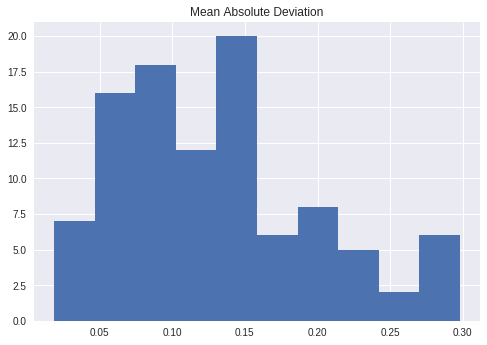

Best:
(array([6, 1, 7, 3]), (0.36574378826270093, 0.6342562117372991, 0, 0), (3.4850537066254006, array([0.36701927, 0.5860726 , 0.04423595, 0.00267218])))
(array([7, 1, 0, 3]), (0.2848057050417235, 0.7151942949582766, 0, 0), (3.631518974589773, array([0.24738522, 0.72579423, 0.00308866, 0.02373189])))
(array([8, 4, 3, 9]), (0.5718278112661049, 0.42817218873389506, 0, 0), (3.5220838609541345, array([0.53270464, 0.40601951, 0.03551842, 0.02575743])))
(array([7, 0, 1, 3]), (0.5826675935593907, 0.4173324064406093, 0, 0), (3.5218020648402866, array([0.50067441, 0.42789434, 0.04315623, 0.02827502])))
(array([9, 0, 5, 3]), (0.3075265710949422, 0.6924734289050578, 0, 0), (3.5763198611698086, array([0.33317361, 0.60979676, 0.01507368, 0.04195595])))
Worst:
(array([1, 5, 9, 8]), (0.19849033770431312, 0.8015096622956869, 0, 0), (4.2819798811096055, array([0.56842835, 0.25856731, 0.06241215, 0.11059219])))
(array([3, 4, 0, 9]), (0.5513960643285315, 0.4486039356714685, 0, 0), (3.5271600826908296, 

In [0]:
analyze_results(conv_vae_four_digit_test_results)

Very incrementally better. What if we pull all the stops, and train a much larger convolutional model, to see how far that might take us?

In [0]:
large_conv_vae = ConvVAE('large_conv_vae', num_filters=16, latent_size=40).to(device)
summary(large_conv_vae, (784, ))

0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2             [-1, 16, 7, 7]           2,320
            Linear-3                   [-1, 40]          31,400
            Linear-4                   [-1, 40]          31,400
            Linear-5                  [-1, 784]          32,144
   ConvTranspose2d-6           [-1, 16, 14, 14]           2,320
   ConvTranspose2d-7            [-1, 1, 28, 28]             145
Total params: 99,889
Trainable params: 99,889
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.38
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


Note this has four times as many parameters as the previous convolutional model...

In [0]:
summary(vae, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                   [-1, 20]           8,020
            Linear-3                   [-1, 20]           8,020
            Linear-4                  [-1, 400]           8,400
            Linear-5                  [-1, 784]         314,384
Total params: 652,824
Trainable params: 652,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.49
Estimated Total Size (MB): 2.51
----------------------------------------------------------------


But due to the efficiency of convolutions overall, under a sixth of the parameters of our original VAE

In [0]:
large_conv_vae_optimizer = optim.Adam(large_conv_vae.parameters(), lr=1e-3)
train_and_test(large_conv_vae, large_conv_vae_optimizer, 20,
              train_loader, test_loader, latent_size=40)

Starting Train Epoch 1



====> Epoch: 1 Average train loss: 198.5759
====> Test set loss: 138.7436
Starting Train Epoch 2



====> Epoch: 2 Average train loss: 128.5656
====> Test set loss: 120.7063
Starting Train Epoch 3



====> Epoch: 3 Average train loss: 118.6819
====> Test set loss: 115.5126
Starting Train Epoch 4



====> Epoch: 4 Average train loss: 115.0420
====> Test set loss: 113.1990
Starting Train Epoch 5



====> Epoch: 5 Average train loss: 113.1260
====> Test set loss: 111.6563
Starting Train Epoch 6



====> Epoch: 6 Average train loss: 111.7681
====> Test set loss: 110.8733
Starting Train Epoch 7



====> Epoch: 7 Average train loss: 110.8832
====> Test set loss: 109.5323
Starting Train Epoch 8



====> Epoch: 8 Average train loss: 110.0675
====> Test set loss: 108.9206
Starting Train Epoch 9



====> Epoch: 9 Average train loss: 109.4057
====> Test set loss: 108.5905
Starting Train Epoch 10



====> Epoch: 10 Average train loss: 108.8921
====> Test set loss: 107.7522
Starting Train Epoch 11



====> Epoch: 11 Average train loss: 108.4697
====> Test set loss: 107.3909
Starting Train Epoch 12



====> Epoch: 12 Average train loss: 108.0544
====> Test set loss: 107.1673
Starting Train Epoch 13



====> Epoch: 13 Average train loss: 107.7170
====> Test set loss: 106.7844
Starting Train Epoch 14



====> Epoch: 14 Average train loss: 107.4237
====> Test set loss: 106.6274
Starting Train Epoch 15



====> Epoch: 15 Average train loss: 107.1506
====> Test set loss: 106.4039
Starting Train Epoch 16



====> Epoch: 16 Average train loss: 106.9801
====> Test set loss: 106.2318
Starting Train Epoch 17



====> Epoch: 17 Average train loss: 106.7739
====> Test set loss: 105.9136
Starting Train Epoch 18



====> Epoch: 18 Average train loss: 106.6123
====> Test set loss: 105.7820
Starting Train Epoch 19



====> Epoch: 19 Average train loss: 106.4603
====> Test set loss: 105.5868
Starting Train Epoch 20



====> Epoch: 20 Average train loss: 106.3111
====> Test set loss: 105.4358


And, just to get a harder upper bound about how expressive the convolutional model might be, let's also train this model with digit mixtures to give it an even better shot. We'll do it with a lower learning rate, to improve the fine-tuning aspect of it. But we might as well try it as an encoder both before and after:

In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


large_conv_vae_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=large_conv_vae, metric=metric)

large_conv_vae_four_digit_test_results = randomized_test(
    simple_four_prob_generator, abc, large_conv_vae_four_digit_abc_params)

0.159705296274842


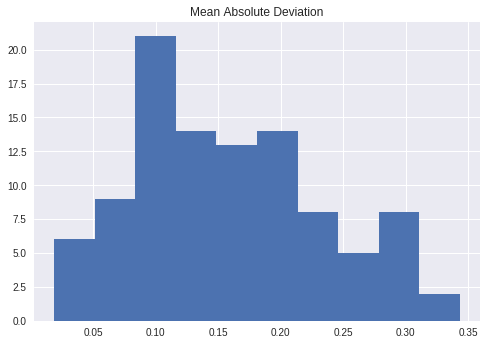

Best:
(array([7, 0, 1, 3]), (0.5826675935593907, 0.4173324064406093, 0, 0), (4.607690675344, array([0.50067441, 0.42789434, 0.04315623, 0.02827502])))
(array([9, 1, 6, 3]), (0.21950767989767056, 0.7804923201023295, 0, 0), (4.1700044866801225, array([0.22817935, 0.72618301, 0.03214626, 0.01349138])))
(array([7, 1, 0, 3]), (0.2848057050417235, 0.7151942949582766, 0, 0), (4.332884632474389, array([0.24738522, 0.72579423, 0.00308866, 0.02373189])))
(array([6, 1, 7, 3]), (0.36574378826270093, 0.6342562117372991, 0, 0), (4.232721739890641, array([0.32161876, 0.65060636, 0.00422752, 0.02354736])))
(array([7, 9, 0, 8]), (0.44942327041877783, 0.5505767295812222, 0, 0), (4.387396304951403, array([0.36603377, 0.60232715, 0.01416545, 0.01747363])))
Worst:
(array([3, 8, 9, 1]), (0.25048552512742905, 0.749514474872571, 0, 0), (4.936318177232087, array([0.07949562, 0.3229975 , 0.0273473 , 0.57015958])))
(array([5, 1, 7, 6]), (0.8121504893203092, 0.1878495106796908, 0, 0), (5.417865625737079, array([0

In [0]:
analyze_results(large_conv_vae_four_digit_test_results)

Interestingly, the large model, by itself, is not actually any better. What if instead of fine-tuning it we simply continute training it for another 20 iterations?

In [0]:
large_conv_vae_optimizer = optim.Adam(large_conv_vae.parameters(), lr=1e-3)
train_and_test(large_conv_vae, large_conv_vae_optimizer, 20,
              train_loader, test_loader, start_epoch=21, latent_size=40)

Starting Train Epoch 21



====> Epoch: 21 Average train loss: 106.3608
====> Test set loss: 105.3295
Starting Train Epoch 22



====> Epoch: 22 Average train loss: 106.0629
====> Test set loss: 105.4298
Starting Train Epoch 23



====> Epoch: 23 Average train loss: 105.8946
====> Test set loss: 105.1294
Starting Train Epoch 24



====> Epoch: 24 Average train loss: 105.8278
====> Test set loss: 105.1469
Starting Train Epoch 25



====> Epoch: 25 Average train loss: 105.7196
====> Test set loss: 105.0195
Starting Train Epoch 26



====> Epoch: 26 Average train loss: 105.6179
====> Test set loss: 104.7820
Starting Train Epoch 27



====> Epoch: 27 Average train loss: 105.5368
====> Test set loss: 104.7432
Starting Train Epoch 28



====> Epoch: 28 Average train loss: 105.4163
====> Test set loss: 104.7477
Starting Train Epoch 29



====> Epoch: 29 Average train loss: 105.4146
====> Test set loss: 104.7561
Starting Train Epoch 30



====> Epoch: 30 Average train loss: 105.3175
====> Test set loss: 104.5791
Starting Train Epoch 31



====> Epoch: 31 Average train loss: 105.1668
====> Test set loss: 104.4472
Starting Train Epoch 32



====> Epoch: 32 Average train loss: 105.1604
====> Test set loss: 104.4069
Starting Train Epoch 33



====> Epoch: 33 Average train loss: 105.1173
====> Test set loss: 104.3754
Starting Train Epoch 34



====> Epoch: 34 Average train loss: 105.0278
====> Test set loss: 104.3738
Starting Train Epoch 35



====> Epoch: 35 Average train loss: 104.9581
====> Test set loss: 104.1144
Starting Train Epoch 36



====> Epoch: 36 Average train loss: 104.8777
====> Test set loss: 104.2330
Starting Train Epoch 37



====> Epoch: 37 Average train loss: 104.8296
====> Test set loss: 104.0885
Starting Train Epoch 38



====> Epoch: 38 Average train loss: 104.7588
====> Test set loss: 104.0810
Starting Train Epoch 39



====> Epoch: 39 Average train loss: 104.7193
====> Test set loss: 104.0181
Starting Train Epoch 40



====> Epoch: 40 Average train loss: 104.6926
====> Test set loss: 103.9872


Let's test it again, post another 20 epochs of training

In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


large_conv_vae_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=large_conv_vae, metric=metric)

large_conv_40_epochs_vae_four_digit_test_results = randomized_test(
    simple_four_prob_generator, abc, large_conv_vae_four_digit_abc_params)

0.15275963406462276


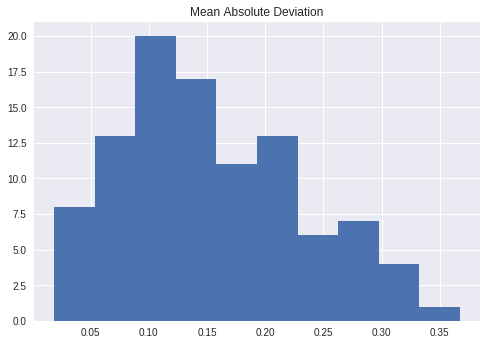

Best:
(array([9, 1, 6, 3]), (0.21950767989767056, 0.7804923201023295, 0, 0), (4.096825783799849, array([0.22817935, 0.72618301, 0.03214626, 0.01349138])))
(array([6, 1, 7, 3]), (0.36574378826270093, 0.6342562117372991, 0, 0), (4.0687587443896165, array([0.32161876, 0.65060636, 0.00422752, 0.02354736])))
(array([7, 1, 0, 3]), (0.2848057050417235, 0.7151942949582766, 0, 0), (4.208041926302733, array([0.24738522, 0.72579423, 0.00308866, 0.02373189])))
(array([7, 0, 1, 3]), (0.5826675935593907, 0.4173324064406093, 0, 0), (4.378756403654581, array([0.50067441, 0.42789434, 0.04315623, 0.02827502])))
(array([9, 0, 5, 3]), (0.3075265710949422, 0.6924734289050578, 0, 0), (4.402986519047164, array([0.33317361, 0.60979676, 0.01507368, 0.04195595])))
Worst:
(array([9, 5, 8, 2]), (0.28749941120887723, 0.7125005887911228, 0, 0), (4.8298726862263734, array([0.43092946, 0.11659009, 0.32711523, 0.12536522])))
(array([2, 9, 4, 1]), (0.8084993468748344, 0.19150065312516562, 0, 0), (5.3631299824830005, ar

In [0]:
analyze_results(large_conv_40_epochs_vae_four_digit_test_results)

Now for the actual fine-tuning:

In [0]:
large_conv_vae_tuning_optimizer = optim.Adam(large_conv_vae.parameters(), lr=1e-3)

def dataset_epoch_callback(epoch):
    mixed_digit_train_dataset.epoch = epoch
    mixed_digit_test_dataset.epoch = epoch
    
train_and_test(large_conv_vae, large_conv_vae_tuning_optimizer, 20, 
              mixed_digit_train_loader, mixed_digit_test_loader,
              dataset_epoch_callback, 41, latent_size=40)

Starting Train Epoch 41



====> Epoch: 41 Average train loss: 169.1047
====> Test set loss: 166.8057
Starting Train Epoch 42



====> Epoch: 42 Average train loss: 166.5812
====> Test set loss: 166.1281
Starting Train Epoch 43



====> Epoch: 43 Average train loss: 166.0699
====> Test set loss: 165.7074
Starting Train Epoch 44



====> Epoch: 44 Average train loss: 166.4305
====> Test set loss: 165.6954
Starting Train Epoch 45



====> Epoch: 45 Average train loss: 165.7703
====> Test set loss: 165.2643
Starting Train Epoch 46



====> Epoch: 46 Average train loss: 165.7196
====> Test set loss: 165.3440
Starting Train Epoch 47



====> Epoch: 47 Average train loss: 165.6471
====> Test set loss: 165.3070
Starting Train Epoch 48


Load the large conv model after training, and test it

In [0]:
large_conv_vae = ConvVAE('large_conv_vae', num_filters=16, latent_size=40).to(device)
large_conv_vae.load_model(60)

0


In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


large_conv_vae_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=large_conv_vae, metric=metric)

large_conv_60_epochs_vae_four_digit_test_results = randomized_test(
    simple_four_prob_generator, abc, large_conv_vae_four_digit_abc_params)

/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


0.1421309379819005


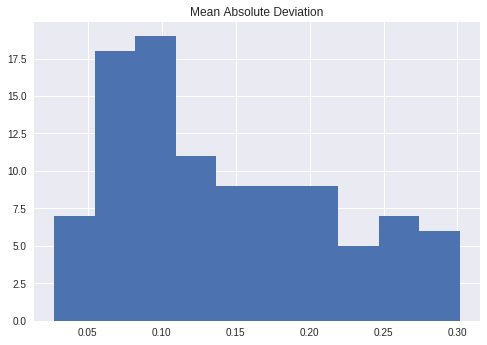

Best:
(array([9, 1, 6, 3]), (0.21950767989767056, 0.7804923201023295, 0, 0), (4.330073154096675, array([0.22817935, 0.72618301, 0.03214626, 0.01349138])))
(array([7, 1, 0, 3]), (0.2848057050417235, 0.7151942949582766, 0, 0), (4.486663050858995, array([0.21682612, 0.7426667 , 0.03403411, 0.00647308])))
(array([7, 0, 1, 3]), (0.5826675935593907, 0.4173324064406093, 0, 0), (4.9826077703231, array([0.50067441, 0.42789434, 0.04315623, 0.02827502])))
(array([9, 0, 5, 3]), (0.3075265710949422, 0.6924734289050578, 0, 0), (5.044806354195957, array([0.33317361, 0.60979676, 0.01507368, 0.04195595])))
(array([8, 6, 4, 2]), (0.6177504913956718, 0.38224950860432816, 0, 0), (5.077008182978999, array([0.52669856, 0.44130573, 0.01026354, 0.02173217])))
Worst:
(array([3, 4, 0, 9]), (0.5513960643285315, 0.4486039356714685, 0, 0), (5.031909949465636, array([0.07378947, 0.35480259, 0.16757127, 0.40383667])))
(array([2, 5, 6, 9]), (0.7889990140736975, 0.21100098592630245, 0, 0), (5.977028320098719, array([0

In [0]:
analyze_results(large_conv_60_epochs_vae_four_digit_test_results)

Fascinatingly, the large convolutional model appears to be worse than the smaller one. Maybe it will prove better on the larger problem, maybe not.

# One last idea: what if we improve the ABC method?

What if rather than doing plain-old ABC, we try ABC-MCMC or ABC-SMC? It will not improve the performance of the encoder, but might prove meaningfully better at exploring the distribution:

To perform ABC-MCMC, we must iteratively sample on the simplex. I thought about simply sampling from a normal proposal, truncating to [0, 1], and ther renormalizing, but I imagined there must be a better way. After some review, I found Director et al.'s (2017) SALT, self-adjusting logit-transform proposal, and decided to implement it. For more information, see here: https://www-tandfonline-com.ccl.idm.oclc.org/doi/abs/10.1080/00949655.2017.1376063?src=recsys&journalCode=gscs20

## SALT pseudocode

* Starting from some $\theta$ in the $k$-dimensional simplex
* Set aside two two out of the $k$ coordinates, the first and last to adjust. Denote them $i$ and $l$ repectively.
* Starting from $\theta_i$, we define $\theta_i' = ilogit( logit(\theta_i) + h_i Z)$, where $Z \sim \mathcal{N}(0, 1), h_i \in \mathbb{R}^+$ 
* Next, for all $j \neq i, l$, we update $\theta_j' = (1 - \theta_i')(\frac{\theta_j}{1-\theta_i} + U_j)$ where $U_j \sim \mathcal{U}(-\epsilon, \epsilon)$
* We then assign all remaining probability mass to $\theta_l' = 1 - \sum_{j \neq l} \theta_j'$ 
* They derive it more thoroughly in the paper, but the transition probability ratio is ends up being $\frac{\theta_i'}{\theta_i} \left( \frac{1 - \theta_i'}{1-\theta_i} \right)^{k-1} $, notably independent of $\epsilon$, so it can be arbitrarily small. 
* The implementaiton below is a fairly faithful translation of their `R` code to Python, sourced from https://rdrr.io/cran/SALTSampler/f/

Quick sanity check to see that it works

In [0]:
logit_values = [scipy.special.logit(np.random.dirichlet(np.ones((10))))]

N_TEST = 10000

for i in range(N_TEST - 1):
    current = logit_values[-1]
    move, log_ratio = salt_proposal(current)
    
    # added sanity 
    if np.any(np.logical_or(np.isnan(move), np.isinf(move))):
        accept = False
    else:
        accept = np.log(np.random.uniform()) < log_ratio # + TODO: add log_probability of score
    
    if accept:
        logit_values.append(move)
    else:
        logit_values.append(current)
    

theta_values = [scipy.special.expit(x) for x in logit_values]
print(np.sum(theta_values) / N_TEST)
print(len(set([tuple(theta) for theta in theta_values])))


0.9988339465748551
8650


Let's try our newfangled ABC-MCMC on this problem, with the best-performing convolutional encoder from before:

In [0]:
def biaesd_four_param_sampler(seed):
    prior_counts = np.array((20, 10, 1, 1))
    np.random.shuffle(prior_counts)
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


conv_vae_four_digit_abc_params = dict(prior_sampler=biaesd_four_param_sampler,
                                          model=conv_vae, metric=metric, n_chains=1)

conv_vae_four_digit_abc_mcmc_test_results = randomized_test(
    simple_four_prob_generator, abc_mcmc_simplex, conv_vae_four_digit_abc_params, num_tests=100)

0.21363963406764325


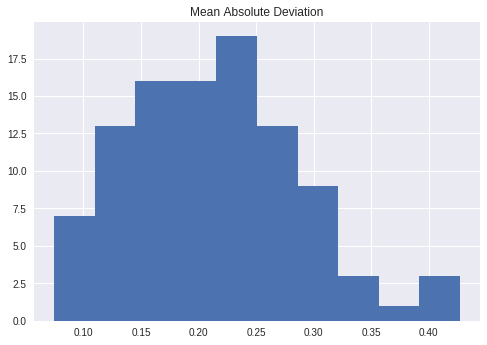

Best:
(array([6, 1, 8, 2]), (0.4650789135548472, 0.5349210864451528, 0, 0), (3.5014910481719053, array([0.32460472, 0.4990169 , 0.16475471, 0.01162368])))
(array([6, 1, 7, 9]), (0.1391105439374341, 0.860889456062566, 0, 0), (3.583738556405653, array([0.02748149, 0.6226444 , 0.03733778, 0.0283942 ])))
(array([6, 1, 2, 9]), (0.5643624768287548, 0.43563752317124516, 0, 0), (3.529086718824513, array([0.40335474, 0.44630228, 0.02529286, 0.12505011])))
(array([9, 2, 6, 3]), (0.6704712419470298, 0.3295287580529702, 0, 0), (3.59045419435794, array([0.45747105, 0.25790275, 0.05414263, 0.01769427])))
(array([7, 9, 8, 2]), (0.4251324106861092, 0.5748675893138908, 0, 0), (3.4427972160097786, array([0.17814954, 0.5511578 , 0.02481558, 0.00236841])))
Worst:
(array([2, 6, 7, 0]), (0.21307195316418756, 0.7869280468358124, 0, 0), (4.05072283636732, array([0.11691922, 0.19925149, 0.38754317, 0.29628611])))
(array([5, 2, 3, 9]), (0.3484909535394871, 0.6515090464605129, 0, 0), (3.859643279948199, array([0

In [0]:
analyze_results(conv_vae_four_digit_abc_mcmc_test_results)

Equally computatonally expensive per iteration, but appears to explore the space substantially worse, at least compared to a biased sampler. It might outperform an unbiased sampler. Let's try one more test, with more chains and iterations per chain, to see if that does anything?

I also changed the proposal sampler to be uniform, since there's no reason to bias the prior for MCMC. 

In [0]:
def uniform_four_param_sampler(seed):
    prior_counts = np.array((1, 1, 1, 1))
    return np.random.dirichlet(prior_counts)


def simple_four_prob_generator(seed):
    # trying to avoid degenerate cases where one p => 0
    # other than the third unused digit, of course
    p = np.random.uniform(0.1, 0.9)
    return (p, 1 - p, 0, 0)


conv_vae_four_digit_abc_params = dict(prior_sampler=uniform_four_param_sampler,
                                          model=conv_vae, metric=metric, n_chains=4, n_iter=400)

conv_vae_four_digit_abc_mcmc_test_results = randomized_test(
    simple_four_prob_generator, abc_mcmc_simplex, conv_vae_four_digit_abc_params, num_tests=20)

0.17942066312620064


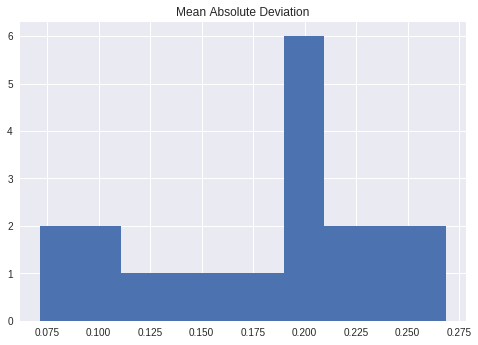

Best:
(array([2, 1, 7, 3]), (0.12041964286044343, 0.8795803571395566, 0, 0), (3.6210682617899526, array([0.06600574, 0.66986343, 0.00159842, 0.02045636])))
(array([7, 1, 5, 0]), (0.3723555048341154, 0.6276444951658846, 0, 0), (3.513367265061169, array([1.18003847e-01, 5.78878600e-01, 9.16499154e-05, 2.70504461e-02])))
(array([9, 1, 7, 0]), (0.5890875406829185, 0.41091245931708154, 0, 0), (3.390567468068809, array([0.41546928, 0.26570776, 0.06060108, 0.02327926])))
(array([9, 6, 3, 7]), (0.6364870269662807, 0.3635129730337193, 0, 0), (3.4006933089941507, array([0.36650104, 0.3432066 , 0.05603548, 0.06448884])))
(array([6, 8, 3, 0]), (0.8518672904373734, 0.14813270956262659, 0, 0), (3.8854150765265207, array([0.50099761, 0.15645672, 0.00869679, 0.09667471])))
Worst:
(array([9, 3, 8, 0]), (0.2458898603019793, 0.7541101396980208, 0, 0), (3.5114500981109953, array([0.23349869, 0.3391991 , 0.26431693, 0.16298528])))
(array([8, 2, 1, 7]), (0.14675013511999718, 0.8532498648800029, 0, 0), (4.01

IndexError: ignored

In [0]:
analyze_results(conv_vae_four_digit_abc_mcmc_test_results)

Update: Improving, both on average, and in terms of the overall best results. Additional iterations would probably help even more, if I had to guess.



## Stumbling points to discuss

* Using sklearn's MNIST and PyTorch's MNIST supposedly interchangably, but they're not - preprocessing or scaling is different, which threw off my model at first.
    * Representing as 0-255 vs floats in 0-1 (without even normalizing, which I could also do)
* Fun with memory management in Colab (see below)
* General challenge of engineering code well with and around Colab

In [0]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In the event I need to nuke and restart the runtime, this cell is handy